In [1]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://pytorch.org/vision/main/models.html

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, random_split


cudnn.benchmark = True
plt.ion()   # interactive mode

C:\Users\johng\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# # https://github.com/jfilter/split-folders
# # Train test split (folders)
# import splitfolders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio("data/tiled_images/keras - Copy", output="data/tiled_images/pytorch",
#     seed=123, ratio=(.8, .2), group_prefix=None, move=True) 




## Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/tiled_images/pytorch/'
# data_dir = 'data/keras_subset - Copy'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

## Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

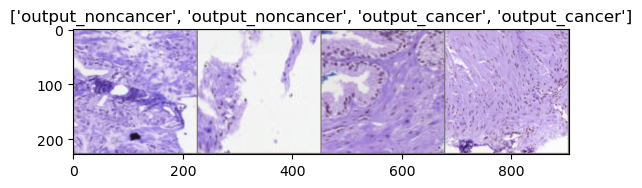

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:
- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.

In [8]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4260 Acc: 0.8198
val Loss: 0.3697 Acc: 0.8532

Epoch 1/4
----------
train Loss: 0.3839 Acc: 0.8444
val Loss: 0.3310 Acc: 0.8750

Epoch 2/4
----------
train Loss: 0.3743 Acc: 0.8495
val Loss: 0.3222 Acc: 0.8774

Epoch 3/4
----------
train Loss: 0.3679 Acc: 0.8524
val Loss: 0.4114 Acc: 0.8677

Epoch 4/4
----------
train Loss: 0.3645 Acc: 0.8550
val Loss: 0.3523 Acc: 0.8652

Training complete in 548m 12s
Best val Acc: 0.877351


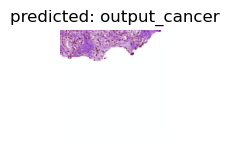

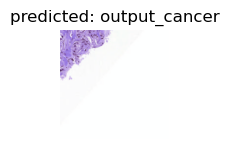

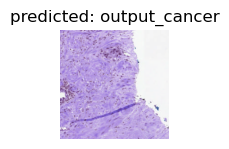

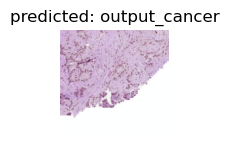

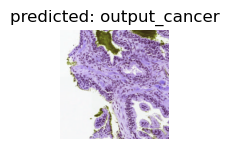

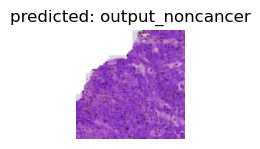

In [10]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [11]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7037 Acc: 0.6889
val Loss: 0.6373 Acc: 0.7107

Epoch 1/4
----------
train Loss: 0.6972 Acc: 0.6946
val Loss: 0.5790 Acc: 0.7314

Epoch 2/4
----------
train Loss: 0.6952 Acc: 0.6978
val Loss: 0.7488 Acc: 0.7490

Epoch 3/4
----------
train Loss: 0.6902 Acc: 0.6992
val Loss: 0.5016 Acc: 0.7871

Epoch 4/4
----------
train Loss: 0.6919 Acc: 0.6985
val Loss: 0.5326 Acc: 0.7826

Training complete in 182m 44s
Best val Acc: 0.787122


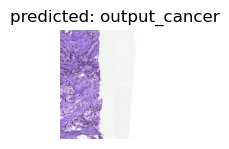

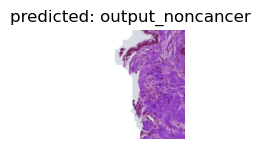

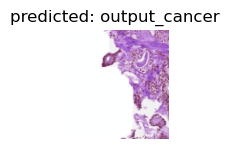

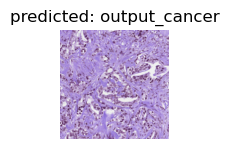

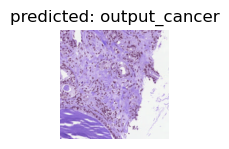

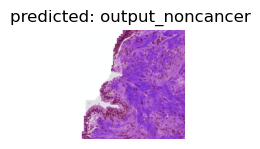

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [14]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert('RGB')
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

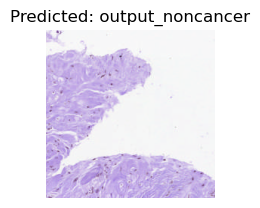

In [15]:
visualize_model_predictions(
    model_conv,
    img_path="data/tiled_images/output/00f6ea010b008e7b3635910a13b165a5_(512, 3840)_noncancer.png"
)

plt.ioff()
plt.show()

In [16]:
# SAVE MODEL 
models_dir = 'models/'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
path = os.path.join(models_dir, 'res50_model_ft.pth')
torch.save(model_ft, path)